In [1]:
from games.kuhn.kuhn import KuhnPoker
from agents.counterfactualregret import CounterFactualRegret
from agents.mcts import MonteCarloTreeSearch
from agents.minimax import MiniMax
from collections import OrderedDict
from base.game import AlternatingGame, AgentID
from base.agent import Agent
import matplotlib.pyplot as plt
import numpy as np
from agents.agent_random import RandomAgent

In [28]:
def play(game, agents: dict[AgentID, tuple[str,Agent]], verbose = True, n=10):
    categories = ["Ganados", "Empatados", "Perdidos"]
    results = {
        agent_id: [0, 0, 0] for agent_id in agents
    }
    rewards = { agent_id: np.zeros(n) for agent_id in agents }

    for i in range(n):
        game.reset()
        if verbose:
            print(f"Initial Agent: {game.agent_selection} ({agents[game.agent_selection][0]})")
        while not game.game_over():
            game.render()
            agent_id = game.agent_selection
            agent_name, agent = agents[agent_id]

            # sobrescribo el juego dado que se crean nuevas instancias
            agent.game = game
            action = agent.action()
            if verbose:
                print(f"Agent {agent_id} ({agent_name}) plays action {action}")
            game.step(action=action)
        game.render()
        if game.truncated():
            if verbose:
                print("Game was truncated")
        for agent_id, (agent_name, _) in agents.items():
            if verbose:
                print(f"Reward agent {agent_id} ({agent_name}): {game.reward(agent_id)}")

        winner = max(game.rewards, key=game.rewards.get)

        if verbose:
            if winner is None:
                print(f"Drawn game")
            else:
                print(f"The winner is: {winner} ({agents[winner][0]})")

        for agent_id in agents:
            rewards[agent_id][i] = game.reward(agent_id)
            if winner is None:
                results[agent_id][1] += 1
            elif winner == agent_id:
                results[agent_id][0] += 1
            else:
                results[agent_id][2] += 1
    
    for agent_id in rewards:
        print(f"Average reward for {agent_id} ({agents[agent_id][0]}): {np.mean(rewards[agent_id])}")

    # Grafico rewards acumulados y cantidad de manos ganadas por cada agente
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

    ax = axes[0]
    games = np.arange(1, n + 1)
    for agent_id, (agent_name, agent) in agents.items():
        ax.plot(games, np.cumsum(rewards[agent_id]) / games, label=agent_name)
    ax.legend()
    ax.set_xlabel('Juegos')
    ax.set_ylabel('Rewards promedios')

    ax = axes[1]
    x = np.arange(len(categories))
    bar_width = 0.35
    agent_ids = list(agents)

    ax.bar(x - bar_width/2, results[agent_ids[0]], bar_width, label=agents[agent_ids[0]][0])
    ax.bar(x + bar_width/2, results[agent_ids[1]], bar_width, label=agents[agent_ids[1]][0])

    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.set_ylabel('Cantidad')
    ax.set_title(f"Comparación de resultados sobre {n} juegos")
    ax.legend()

    plt.show()

### Entrenamiento

Cambios con respecto al notebook original, para entrenamiento no se fija el jugado inicial, además se modificó el ambiente para que retorne los rewards teniendo en cuenta el jugado que arranca la partida. En los infosets del algoritmo (node_dict) de CFR, se agrega un key que es el agent que le toca jugar para simplificar el código de train de abajo en el que se usa un solo entrenamiento que obtiene diferentes infosets por agente (númericamente diferentes pero bastante similares).

In [4]:
game = KuhnPoker(fix_initial_player=False)
cfr = CounterFactualRegret(game=game, agent=game.agents[0])
cfr.train(1000000)
for agent_id in game.agents:
    print(OrderedDict(map(lambda n: (n, cfr.node_dict[agent_id][n].policy()), sorted(cfr.node_dict[agent_id].keys()))))

OrderedDict([('0', array([0.73556147, 0.26443853])), ('0b', array([9.99996993e-01, 3.00684960e-06])), ('0p', array([0.66166436, 0.33833564])), ('0pb', array([9.99997961e-01, 2.03941352e-06])), ('1', array([9.99918859e-01, 8.11409405e-05])), ('1b', array([0.6548783, 0.3451217])), ('1p', array([9.99965844e-01, 3.41562872e-05])), ('1pb', array([0.39835715, 0.60164285])), ('2', array([0.20617956, 0.79382044])), ('2b', array([3.00048008e-06, 9.99997000e-01])), ('2p', array([2.40038406e-05, 9.99975996e-01])), ('2pb', array([7.26747920e-06, 9.99992733e-01]))])
OrderedDict([('0', array([0.79853378, 0.20146622])), ('0b', array([9.99996999e-01, 3.00111041e-06])), ('0p', array([0.66808228, 0.33191772])), ('0pb', array([9.99998118e-01, 1.88242597e-06])), ('1', array([9.99977196e-01, 2.28040494e-05])), ('1b', array([0.65485181, 0.34514819])), ('1p', array([9.99994013e-01, 5.98709183e-06])), ('1pb', array([0.46133641, 0.53866359])), ('2', array([0.40064471, 0.59935529])), ('2b', array([2.98917917e-0

### Antes de ejecutar las pruebas en las siguientes celdas se verifica que CFR entrene bien comparando contra los resultados teóricos para kuhn poker.

In [11]:
print('Check learned policies against theoretical policies:')

Check learned policies against theoretical policies:


In [16]:
learned_info_sets = cfr.node_dict[game.agents[0]]

In [17]:
JX_b = learned_info_sets['0'].policy()[1]
print(f'Agent: 0 - Hand: J_ - History: [] - Probability of betting: {JX_b}')


Agent: 0 - Hand: J_ - History: [] - Probability of betting: 0.2644385303942367


In [18]:
QX_pb_b = learned_info_sets['1pb'].policy()[1]
print(f'Agent: 0 - Hand: Q_ - History: pb - Probability of betting: {QX_pb_b} - Theoretic value: {JX_b+1/3} -  Difference: {abs(QX_pb_b - (JX_b+1/3))}')


Agent: 0 - Hand: Q_ - History: pb - Probability of betting: 0.601642849889714 - Theoretic value: 0.59777186372757 -  Difference: 0.0038709861621439856


In [20]:
KX_b = learned_info_sets['2'].policy()[1]
print(f'Agent: 0 - Hand: K_ - History: [] - Probability of betting: {KX_b} - Theoretic value: {3 * JX_b} -  Difference: {abs(KX_b - 3 * JX_b)}')


Agent: 0 - Hand: K_ - History: [] - Probability of betting: 0.7938204355120468 - Theoretic value: 0.7933155911827101 -  Difference: 0.0005048443293367288


In [21]:
XJ_p_b = learned_info_sets['0p'].policy()[1]
print(f'Agent: 0 - Hand: _J - History: p - Probability of betting: {XJ_p_b} - Theoretic value: {1/3} -  Difference: {abs(XJ_p_b - 1/3)}')

Agent: 0 - Hand: _J - History: p - Probability of betting: 0.338335635640303 - Theoretic value: 0.3333333333333333 -  Difference: 0.005002302306969686


In [22]:
XQ_b_b = learned_info_sets['1b'].policy()[1]
print(f'Agent: 0 - Hand: _Q - History: b - Probability of betting: {XQ_b_b} - Theoretic value: {1/3} -  Difference: {abs(XQ_b_b - 1/3)}')

Agent: 0 - Hand: _Q - History: b - Probability of betting: 0.34512169918064106 - Theoretic value: 0.3333333333333333 -  Difference: 0.011788365847307747


### Pruebas

Ahora si para las pruebas se fija en el kuhn que arranque siempre el agent 0

In [25]:
fixed_game = KuhnPoker(fix_initial_player=True)
cfr.game = fixed_game
cfr2 = CounterFactualRegret(game=fixed_game, agent=game.agents[1])
cfr2.node_dict = cfr.node_dict

#### Random vs CFR

Initial Agent: agent_0 (Random)
agent_0 Q 
agent_1 K 
Agent agent_0 (Random) plays action 1
agent_0 Q b
agent_1 K b
Agent agent_1 (CFR) plays action 1
agent_0 Q bb
agent_1 K bb
Reward agent agent_0 (Random): -2
Reward agent agent_1 (CFR): 2
The winner is: agent_1 (CFR)
Initial Agent: agent_0 (Random)
agent_0 J 
agent_1 K 
Agent agent_0 (Random) plays action 1
agent_0 J b
agent_1 K b
Agent agent_1 (CFR) plays action 1
agent_0 J bb
agent_1 K bb
Reward agent agent_0 (Random): -2
Reward agent agent_1 (CFR): 2
The winner is: agent_1 (CFR)
Initial Agent: agent_0 (Random)
agent_0 J 
agent_1 Q 
Agent agent_0 (Random) plays action 1
agent_0 J b
agent_1 Q b
Agent agent_1 (CFR) plays action 0
agent_0 J bp
agent_1 Q bp
Reward agent agent_0 (Random): 1
Reward agent agent_1 (CFR): -1
The winner is: agent_0 (Random)
Initial Agent: agent_0 (Random)
agent_0 J 
agent_1 Q 
Agent agent_0 (Random) plays action 0
agent_0 J p
agent_1 Q p
Agent agent_1 (CFR) plays action 0
agent_0 J pp
agent_1 Q pp
Reward age

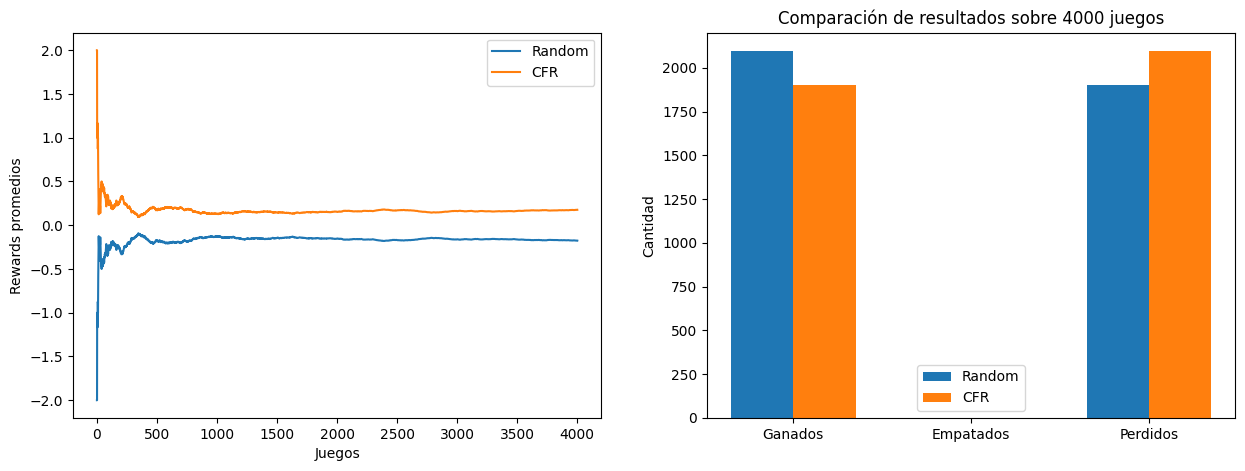

In [32]:
play(fixed_game, {
    game.agents[0]: ("Random", RandomAgent(game=fixed_game, agent=game.agents[0])),
    game.agents[1]: ("CFR", cfr2),
}, n=4000)

#### CFR vs Random

Initial Agent: agent_0 (CFR)
agent_0 Q 
agent_1 J 
Agent agent_0 (CFR) plays action 0
agent_0 Q p
agent_1 J p
Agent agent_1 (Random) plays action 0
agent_0 Q pp
agent_1 J pp
Reward agent agent_0 (CFR): 1
Reward agent agent_1 (Random): -1
The winner is: agent_0 (CFR)
Initial Agent: agent_0 (CFR)
agent_0 Q 
agent_1 K 
Agent agent_0 (CFR) plays action 0
agent_0 Q p
agent_1 K p
Agent agent_1 (Random) plays action 0
agent_0 Q pp
agent_1 K pp
Reward agent agent_0 (CFR): -1
Reward agent agent_1 (Random): 1
The winner is: agent_1 (Random)
Initial Agent: agent_0 (CFR)
agent_0 J 
agent_1 Q 
Agent agent_0 (CFR) plays action 1
agent_0 J b
agent_1 Q b
Agent agent_1 (Random) plays action 1
agent_0 J bb
agent_1 Q bb
Reward agent agent_0 (CFR): -2
Reward agent agent_1 (Random): 2
The winner is: agent_1 (Random)
Initial Agent: agent_0 (CFR)
agent_0 J 
agent_1 K 
Agent agent_0 (CFR) plays action 0
agent_0 J p
agent_1 K p
Agent agent_1 (Random) plays action 1
agent_0 J pb
agent_1 K pb
Agent agent_0 (CFR)

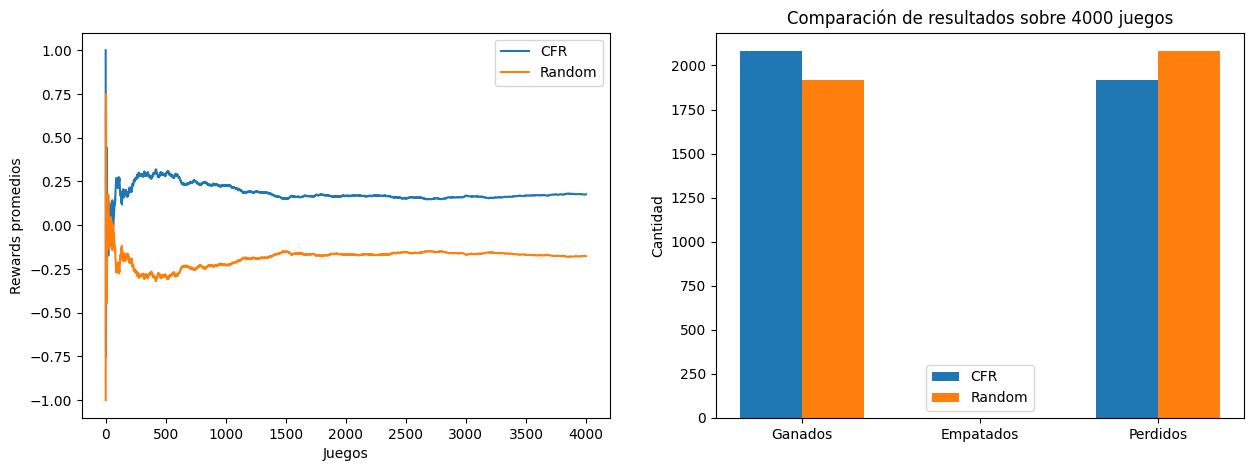

In [33]:
play(fixed_game, {
    game.agents[0]: ("CFR", cfr),
    game.agents[1]: ("Random", RandomAgent(game=fixed_game, agent=game.agents[1]))
}, n=4000)

#### CFR vs CFR fijando la posición inicial

Initial Agent: agent_0 (CFR_position_0)
agent_0 J 
agent_1 K 
Agent agent_0 (CFR_position_0) plays action 0
agent_0 J p
agent_1 K p
Agent agent_1 (CFR_position_1) plays action 1
agent_0 J pb
agent_1 K pb
Agent agent_0 (CFR_position_0) plays action 0
agent_0 J pbp
agent_1 K pbp
Reward agent agent_0 (CFR_position_0): -1
Reward agent agent_1 (CFR_position_1): 1
The winner is: agent_1 (CFR_position_1)
Initial Agent: agent_0 (CFR_position_0)
agent_0 J 
agent_1 K 
Agent agent_0 (CFR_position_0) plays action 0
agent_0 J p
agent_1 K p
Agent agent_1 (CFR_position_1) plays action 1
agent_0 J pb
agent_1 K pb
Agent agent_0 (CFR_position_0) plays action 0
agent_0 J pbp
agent_1 K pbp
Reward agent agent_0 (CFR_position_0): -1
Reward agent agent_1 (CFR_position_1): 1
The winner is: agent_1 (CFR_position_1)
Initial Agent: agent_0 (CFR_position_0)
agent_0 K 
agent_1 Q 
Agent agent_0 (CFR_position_0) plays action 1
agent_0 K b
agent_1 Q b
Agent agent_1 (CFR_position_1) plays action 0
agent_0 K bp
agent_1

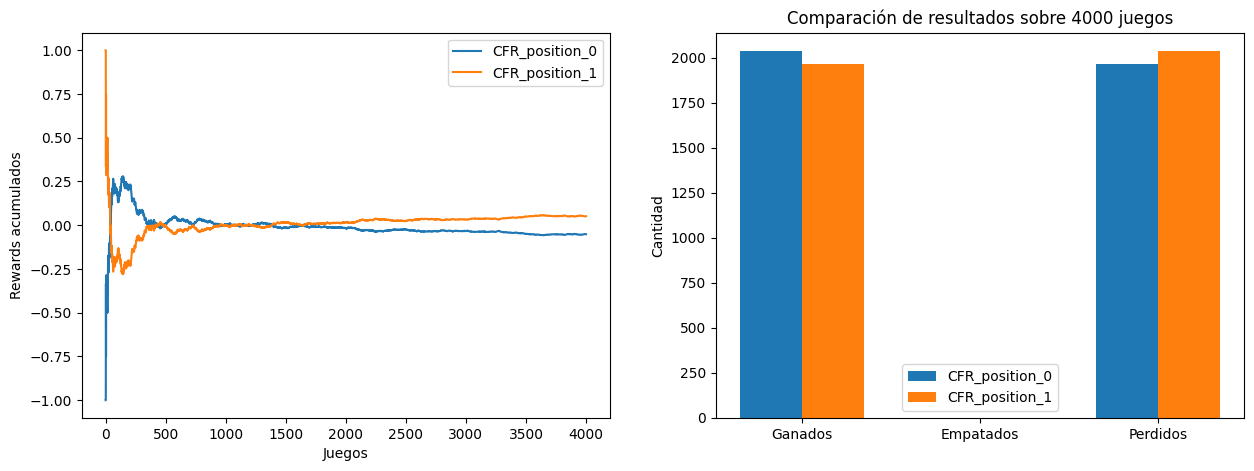

In [27]:
play(fixed_game, {
    game.agents[0]: ("CFR_position_0", cfr),
    game.agents[1]: ("CFR_position_1", cfr2),
}, n=4000)